# Investor Owned Utilities Data
In this Ipython notebook, I will use beautifulsoup to scrape a table of Investor Owned Utilities from Wikipedia. It gets a bit tricky because some rows have a pesky problem with rowspan.

In [22]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)



In [2]:
IOU='https://en.wikipedia.org/wiki/Investor-owned_utility' #the wikipedia link

In [3]:
page=urllib2.urlopen(IOU)

In [4]:
page.geturl() # make sure no redirect

'https://en.wikipedia.org/wiki/Investor-owned_utility'

In [5]:
soup=BeautifulSoup(page,'lxml')

In [6]:
print soup.prettify()

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Investor-owned utility - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Investor-owned_utility","wgTitle":"Investor-owned utility","wgCurRevisionId":705277138,"wgRevisionId":705277138,"wgArticleId":9866936,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Public utilities","All stub articles","Business stubs"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February

In [7]:
soup.title.string

u'Investor-owned utility - Wikipedia'

In [8]:
right_table=soup.find('table', {'class':'wikitable sortable'}) # The class of the table is wikitable sortable
print right_table

<table class="wikitable sortable" style="text-align: left;">
<tr>
<th>Parent Company</th>
<th>Operating Company</th>
<th>Operating States</th>
</tr>
<tr>
<td rowspan="2"><a href="/wiki/AES_Corporation" title="AES Corporation">AES Corporation</a></td>
<td><a href="/wiki/Indianapolis_Power_%26_Light" title="Indianapolis Power &amp; Light">Indianapolis Power &amp; Light</a></td>
<td>IN</td>
</tr>
<tr>
<td><a href="/wiki/DPL_Inc." title="DPL Inc.">Dayton Power and Light</a></td>
<td>OH</td>
</tr>
<tr>
<td rowspan="2">Allete</td>
<td>Minnesota Power</td>
<td>MN</td>
</tr>
<tr>
<td>Superior Water, Light and Power</td>
<td>WI</td>
</tr>
<tr>
<td rowspan="2"><a href="/wiki/Alliant_Energy" title="Alliant Energy">Alliant Energy</a></td>
<td>Interstate Power and Light</td>
<td>IA, MN</td>
</tr>
<tr>
<td>Wisconsin Power and Light</td>
<td>WI</td>
</tr>
<tr>
<td rowspan="2"><a href="/wiki/Ameren" title="Ameren">Ameren</a></td>
<td><a href="/wiki/Central_Illinois_Public_Service_Company" title="Centr

We can see the problem with rowspan. Some rows of the first column have a rowspan number. For instance if there's a rowspan of 2, that value spans over 2 rows. However, without taking proper care to adjust for this, we would lose the data for the second row. The problem obviously gets worse the larger the rowspan number is

In [9]:
#change rowsleft into something else
rowspans = [] #use this to save data on rows with a rowspan variable
dd=[]
for row in right_table.findAll("tr"): #find all the rows in the table
    cells = row.findAll(["th", "td"]) #Headers and columns
    if len(rowspans) == 0:
        rowspans = [None for row in cells] #define rowspans by the number of columns
    for i, cell in enumerate(cells):
        if cell.has_attr("rowspan"):
            rowspan_data = {'rows_left': int(cell["rowspan"]),'value': cell,}
            rowspans[i] = rowspan_data
        elif len(cells) != len(rowspans):
            for index, rowspan_data in enumerate(rowspans):
                if rowspan_data is not None:# Insert the data from previous row; decrement rows left
                    cells.insert(index, rowspan_data['value'])
                    if rowspans[index]['rows_left'] == 1:
                        rowspans[index] = None     
                    else:
                        rowspans[index]['rows_left'] -= 1
                        
    dd.append(cells)


In [10]:
PC=[]
OC=[]
OS=[]
for row in dd:
    PC.append(row[0].find(text=True))
    OC.append(row[1].find(text=True))
    OS.append(row[2].find(text=True))

In [11]:
df=pd.DataFrame(PC) #create a dataframe 
df['Operating Company']=OC
df['State']=OS
df.columns=df.iloc[0] #set the first row as the header

In [12]:
df=df.ix[1:,] 

In [13]:
df=df.reset_index()
del df['index']

In [14]:
df

,Parent Company,Operating Company,Operating States
0,AES Corporation,Indianapolis Power & Light,IN
1,AES Corporation,Dayton Power and Light,OH
2,Allete,Minnesota Power,MN
3,Allete,"Superior Water, Light and Power",WI
4,Alliant Energy,Interstate Power and Light,"IA, MN"
5,Alliant Energy,Wisconsin Power and Light,WI
6,Ameren,Ameren Illinois,IL
7,Ameren,Ameren Missouri,MO
8,American Electric Power,AEP Ohio,"OH, WV"
9,American Electric Power,AEP Texas,TX


Create tickers for publicly traded companies

In [15]:
ticker=[]
for i in range(len(df)):
    if df['Parent Company'].str.contains('AES')[i]==True:
        ticker.append('AES')
    elif df['Parent Company'].str.contains('FirstEnergy')[i]==True:
        ticker.append('FE')
    elif df['Parent Company'].str.contains('American Elect')[i]==True:
        ticker.append('AEP')
    elif df['Parent Company'].str.contains('Dominion')[i]==True:
        ticker.append('D')
    elif df['Parent Company'].str.contains('Allete')[i]==True:
        ticker.append('ALE')
    elif df['Parent Company'].str.contains('PPL')[i]==True:
        ticker.append('PPL')
    elif df['Parent Company'].str.contains('Duke')[i]==True:
        ticker.append('DUK')
    elif df['Parent Company'].str.contains('Xcel')[i]==True:
        ticker.append('XEL')
    elif df['Parent Company'].str.contains('Alliant')[i]==True:
        ticker.append('LNT')
    elif df['Parent Company'].str.contains('Exelon')[i]==True:
        ticker.append('EXC')
    elif df['Parent Company'].str.contains('Entergy')[i]==True:
        ticker.append('ETR')
    elif df['Parent Company'].str.contains('Hawaii')[i]==True:
        ticker.append('HE')
    elif df['Parent Company'].str.contains('Consolidated Edison')[i]==True:
        ticker.append('ED')
    elif df['Parent Company'].str.contains('Southern Company')[i]==True:
        ticker.append('SO')
    elif df['Parent Company'].str.contains('Ameren')[i]==True:
        ticker.append('AEE')
    elif df['Parent Company'].str.contains('Unitil')[i]==True:
        ticker.append('UTL')
    elif df['Parent Company'].str.contains('Pepco')[i]==True:
        ticker.append('POM')
    elif df['Parent Company'].str.contains('Black Hills')[i]==True:
        ticker.append('BKH')
    elif df['Parent Company'].str.contains('Avista')[i]==True:
        ticker.append('AVA')
    elif df['Parent Company'].str.contains('ITC Holdings')[i]==True:
        ticker.append('ITC')
    elif df['Parent Company'].str.contains('National Grid')[i]==True:
        ticker.append('NGG')
    elif df['Parent Company'].str.contains('CenterPoint')[i]==True:
        ticker.append('CNP')
    elif df['Parent Company'].str.contains('UniSource')[i]==True:
        ticker.append('UNS')
    elif df['Parent Company'].str.contains('CLECO')[i]==True:
        ticker.append('CNL')
    elif df['Parent Company'].str.contains('PNM')[i]==True:
        ticker.append('PNM')
    elif df['Parent Company'].str.contains('Westar')[i]==True:
        ticker.append('WR')
    elif df['Parent Company'].str.contains('El Paso')[i]==True:
        ticker.append('EE')
    elif df['Parent Company'].str.contains('CMS Energy')[i]==True:
        ticker.append('CMS')
    elif df['Parent Company'].str.contains('Wisconsin Energy')[i]==True:
        ticker.append('WEC')
    elif df['Parent Company'].str.contains('Great Plains')[i]==True:
        ticker.append('GXP')
    elif df['Parent Company'].str.contains('MDU')[i]==True:
        ticker.append('MDU')
    elif df['Parent Company'].str.contains('DTE')[i]==True:
        ticker.append('DTE')
    elif df['Parent Company'].str.contains('Edison International')[i]==True:
        ticker.append('EIX')
    elif df['Parent Company'].str.contains('Vectren')[i]==True:
        ticker.append('VVC')
    elif df['Parent Company'].str.contains('UIL Holdings')[i]==True:
        ticker.append('UIL')
    elif df['Parent Company'].str.contains('Sempra')[i]==True:
        ticker.append('SRE')
    elif df['Parent Company'].str.contains('Integrys')[i]==True:
        ticker.append('TEG')
    elif df['Parent Company'].str.contains('NextEra')[i]==True:
        ticker.append('NEE')
    elif df['Parent Company'].str.contains('MGE')[i]==True:
        ticker.append('MGE')
    elif df['Parent Company'].str.contains('OGE')[i]==True:
        ticker.append('OGE')
    elif df['Parent Company'].str.contains('NiSource')[i]==True:
        ticker.append('NI')
    elif df['Parent Company'].str.contains('NSTAR')[i]==True:
        ticker.append('NST')
    elif df['Parent Company'].str.contains('TECO')[i]==True:
        ticker.append('TE')
    elif df['Parent Company'].str.contains('PG&E')[i]==True:
        ticker.append('PCG')
    elif df['Parent Company'].str.contains('NorthWestern Corp')[i]==True:
        ticker.append('NWE')
    elif df['Parent Company'].str.contains('NRG')[i]==True:
        ticker.append('NRG')
    elif df['Parent Company'].str.contains('Otter Tail')[i]==True:
        ticker.append('OTTR')
    elif df['Parent Company'].str.contains('Public Service Enterprise')[i]==True:
        ticker.append('PEG')
    elif df['Parent Company'].str.contains('Puget')[i]==True:
        ticker.append('PSD')
    elif df['Parent Company'].str.contains('SCANA')[i]==True:
        ticker.append('SCG')
    elif df['Parent Company'].str.contains('UGI Corp')[i]==True:
        ticker.append('UGI')
    elif df['Parent Company'].str.contains('Portland Gen')[i]==True:
        ticker.append('POR')
    elif df['Parent Company'].str.contains('Pinnacle West')[i]==True:
        ticker.append('PNW')
    elif df['Parent Company'].str.contains('Northeast Utilities')[i]==True:
        ticker.append('NU')
    elif df['Parent Company'].str.contains('DQE')[i]==True:
        ticker.append('DQE')
    else:
        ticker.append('')
df['ticker']=ticker

### What parent companies have the most utilities?

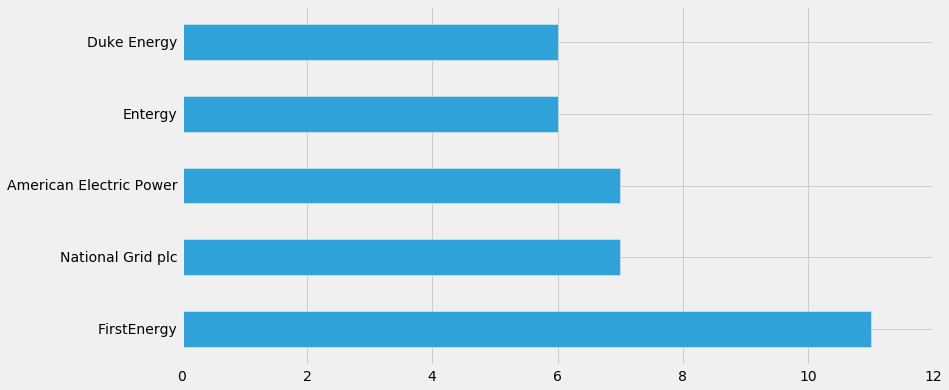

In [23]:
df['Parent Company'].value_counts().head().plot(kind='barh')

### What parent companies have the least number of utilities?

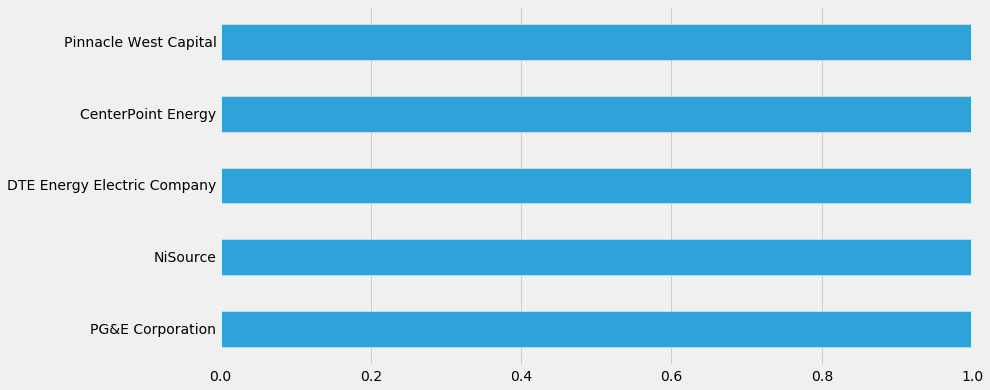

In [24]:
df['Parent Company'].value_counts().tail().plot(kind='barh')